# Depth Metrics

This repository/notebook aims to implement the affine invariant protocol for relative monocular depth estimation models

- Step 1: Load the data.

- Step 2: Pre-process: Transform into disparity, apply masks, deal with zero division.

- Step 3: Align the prediction with groundtruth with least squares algorithm

- Step 4: Calculate the Metrics (AbsRel, delta, RMSE)

- Step 5: Output the results in pandas dataframe and figures.  

### Coisas pra fazer:

1) **Zero Division**: Modificar cálculos para evitar divisão por zero  (check)

2) **Métricas**: implementar o código para outras métricas (delta123, RMSE) (check)
   1) Visualização: Pode cortar os valores extremantes da imagem para avaliação ou para visualização?
   2) ARRUMAR AS MASCARAS PARA AS IMAGENS EXTERNAS

3) **Loop de teste**: fazer rodar para todas as imagens do dataset   

4) **Saída**: salvar em dataframe  
   1) Dataframe com delta, absrel e...

5) **Realizar testes**: Teste no código de teste
   1) Imagens sintéticas com erros conhecidos para testar
   
6) Rodar nos outros datasets
   1) Codar individualmente o teste para cada um
   2) pensar numa maneira de isolar o carregamento dos dados
   
7) Exibir resultados de outras formas
   1) Codificar teste de erro por distância
   2) gerar imagens de erro
   3) pesquisar outras formas...

In [316]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from utils import (get_sorted_files,  
                   abs_rel_error, 
                   cap_values, 
                   plot_histogram,  
                   depth_report, 
                   align_depth,
                   calculate_delta,
                   generate_flat_array,
                   depth_infos)


# Affine-Invariant Alignment

## 1. Load data

In [317]:
diode_path = Path("/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/")
diode_indoor = diode_path / "val" / "indoors"
diode_outdoor = diode_path / "val" / "outdoor"
diode_preds = Path("/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/")

filenames_img = get_sorted_files(diode_path, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_preds, ".npy")

In [318]:
index = 85
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.squeeze(np.load(filenames_depth[index]))
rgb = np.array(Image.open(filenames_img[index]))
H,W = groundtruth.shape
mask = np.load(filenames_mask[index]).reshape((H, W))

## 2. Pre Processing

In [319]:
mask_pred = np.ones_like(pred_diode)
mask_pred[pred_diode == 0] = 0

In [320]:
groundtruth_masked = np.zeros_like(groundtruth)
groundtruth_masked[mask == 1] = groundtruth[mask == 1]

disparity_gt_masked = np.zeros_like(groundtruth)
disparity_gt_masked[mask == 1] = 1.0 / groundtruth[mask == 1]

pred_depth = np.zeros_like(groundtruth) 
pred_depth[mask_pred == 1] = 1.0 / pred_diode[mask_pred == 1]

groundtruth_capped_upper = cap_values(groundtruth, 0, 99)
disparity_capped_upper = cap_values(disparity_gt_masked, 0, 99)

Visualization of the data 

- a) RGB Image
- b) Prediction from model in UINT8
- c) Groundtruth depth in UINT8
- d) Histogram from depth groundtruth

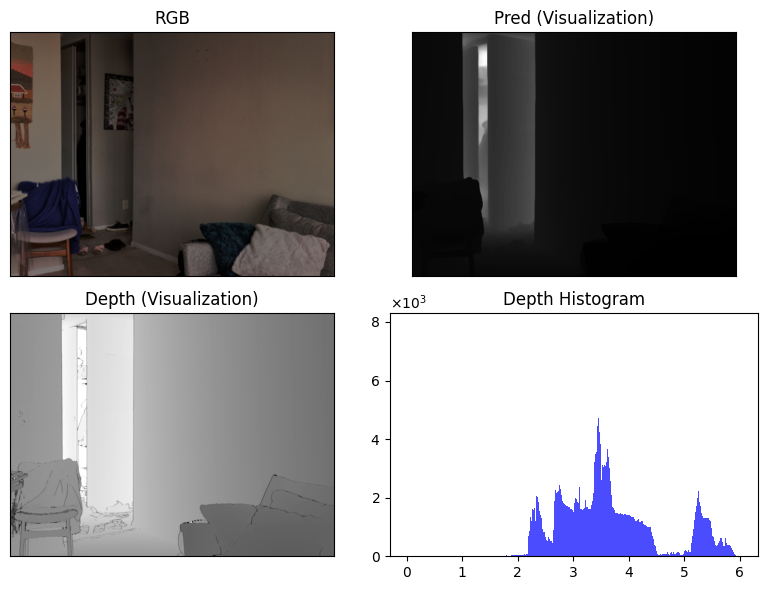

---- Depth Report ----

how many uniques: 734752
Max: 6.027100563049316
Min: 0.0
shape: (768, 1024)
Dtype: float32
---- Depth Report ----

how many uniques: 766815
Max: 0.07805752754211426
Min: 0.0016423924826085567
shape: (768, 1024)
Dtype: float32


In [321]:
depth_report(rgb, groundtruth_capped_upper, pred_depth, cap=False, uint=False)

## 3. Alignment via least squares algorithm

### debugging

In [322]:
flat_gt_masked = generate_flat_array(groundtruth_capped_upper, mask)
flat_pred_masked = generate_flat_array(pred_diode, mask)

In [323]:
depth_infos(flat_pred_masked)

---- Depth Report ----

how many uniques: 752186
Max: 608.8678588867188
Min: 25.792720794677734
shape: (767423,)
Dtype: float32


In [324]:
def compute_scale_and_shift(prediction, target, mask):
        # h,w = prediction.shape
        # prediction = prediction.reshape((1,h,w))
        # target = target.reshape((1,h,w))
        # mask = mask.reshape((1,h,w))
        # system matrix: A = [[a_00, a_01], [a_10, a_11]]
        a_00 = np.sum(mask * prediction * prediction, (0,1))
        a_01 = np.sum(mask * prediction, (0,1))
        a_11 = np.sum(mask, (0,1))

        # right hand side: b = [b_0, b_1]
        b_0 = np.sum(mask * prediction * target, (0,1))
        b_1 = np.sum(mask * target, (0,1))

        # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
        x_0 = np.zeros_like(b_0)
        x_1 = np.zeros_like(b_1)

        det = a_00 * a_11 - a_01 * a_01
        # A needs to be a positive definite matrix.
        valid = det > 0

        x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
        x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

        return x_0, x_1

In [325]:
x_0, x_1 = compute_scale_and_shift(pred_diode, disparity_capped_upper, mask)

In [328]:
prediction_aligned = x_0 * pred_diode + x_1
prediction_aligned = np.squeeze(prediction_aligned)

depth_aligned_masked = np.zeros_like(pred_diode)
depth_aligned_masked[mask == 1] = 1 / prediction_aligned[mask == 1]

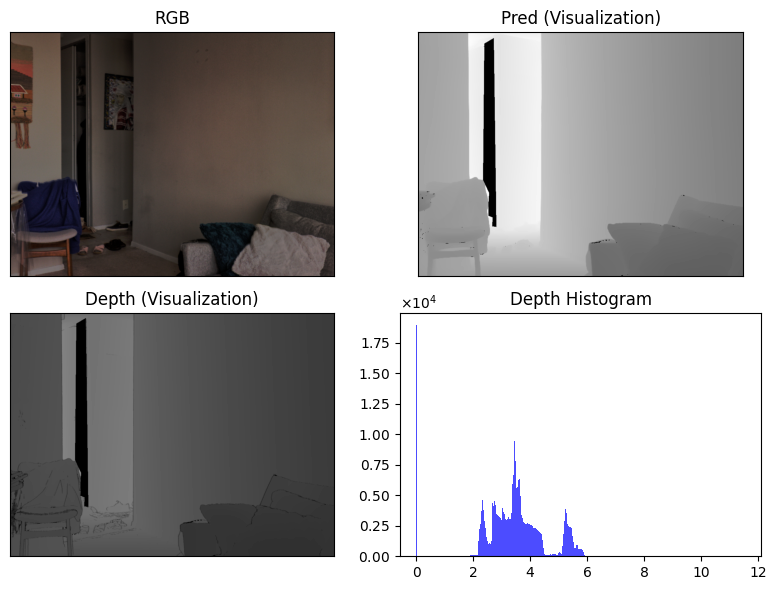

---- Depth Report ----

how many uniques: 724382
Max: 11.546958923339844
Min: 0.0
shape: (768, 1024)
Dtype: float32
---- Depth Report ----

how many uniques: 729235
Max: 5.58341646194458
Min: 0.0
shape: (768, 1024)
Dtype: float32


In [329]:
depth_report(rgb, groundtruth_masked,depth_aligned_masked, cap=False, uint=False)

----------------

Histogram of the groundtruth and depth aligned

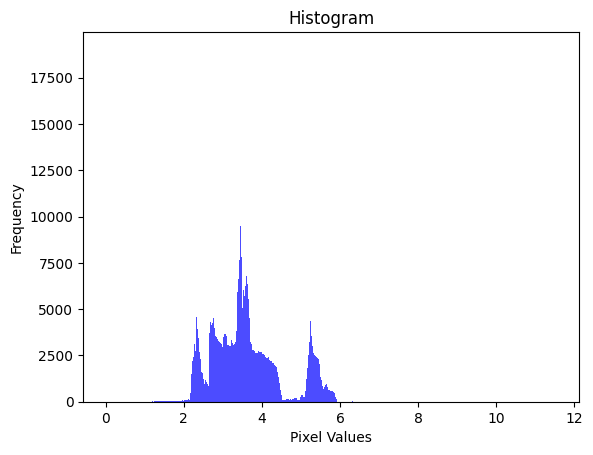

In [330]:
plot_histogram(groundtruth_masked)

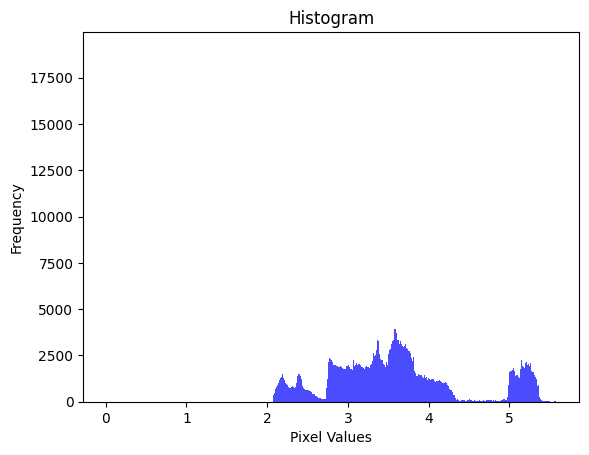

In [331]:
plot_histogram(depth_aligned_masked)

Visualization of a column of the groundtruth, and from the prediction. Then, align them both.

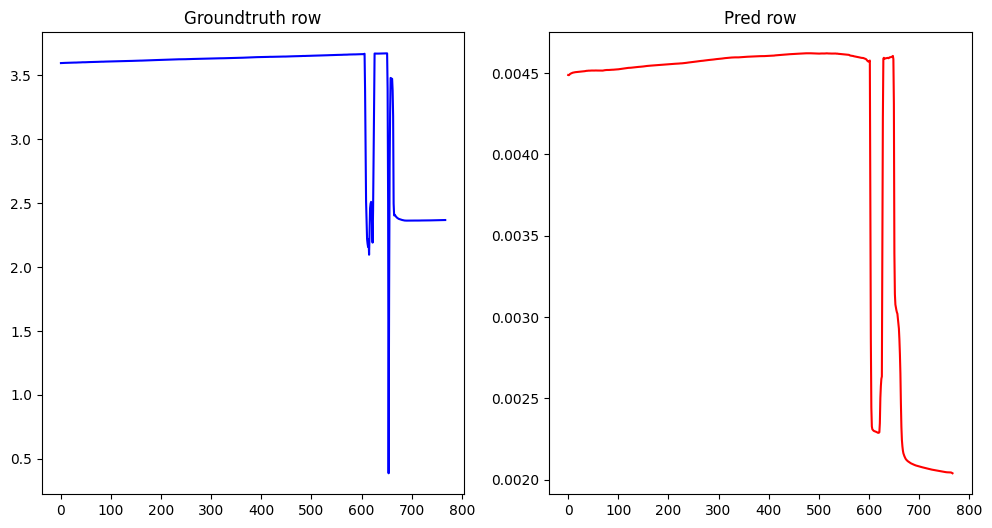

In [332]:
row_index = 600
GT_row = groundtruth_capped_upper[:, row_index]
pred_row = pred_depth[:, row_index]
pred_aligned_row = depth_aligned_masked[:, row_index]


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot( GT_row, 'b')
ax[0].set_title("Groundtruth row")
ax[1].plot(pred_row, 'r')
ax[1].set_title("Pred row")
plt.show()

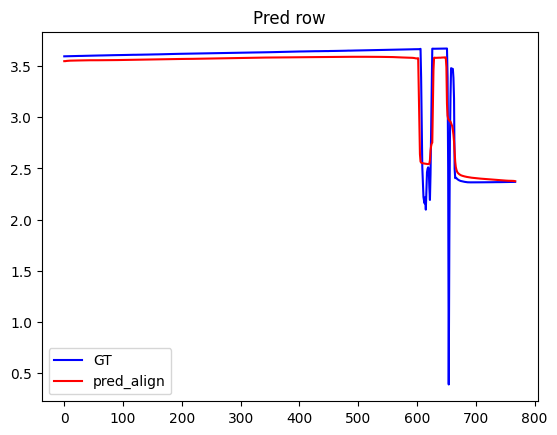

In [333]:
fig, ax = plt.subplots()
ax.plot(GT_row, 'b',label="GT")
ax.plot(pred_aligned_row, 'r', label="pred_align")
ax.set_title("Pred row")
ax.legend()
plt.show()

## 4. Calculate Metrics

### 4.1 metrics on groundtruth masked

In [334]:
abs_rel_error(depth_aligned_masked, groundtruth_masked)

np.float32(0.036343694)

In [335]:
calculate_delta(depth_aligned_masked, groundtruth_masked, mask, threshold=1.25)

np.float64(98.65706396602656)

### 4.2 metrics on groundtruth capped

In [336]:
abs_rel_error(depth_aligned_masked, groundtruth_capped_upper)

np.float32(0.060207)

In [337]:
calculate_delta(depth_aligned_masked, groundtruth_capped_upper, mask, threshold=1.25)

np.float64(98.65706396602656)

## 5. Output the results